<a href="https://colab.research.google.com/github/florsastre-gif/Collaboration-For-Beginners/blob/master/MicroProyecto_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OBJETIVO= Diseñar un pipeline completo para abordar una tarea de Procesamiento de Lenguaje Natural (NLP) usando un dataset real.


⚡️ Problema elegido: clasificación binaria de sentimiento a partir de texto.

In [1]:
import re
import io
import numpy as np
import pandas as pd

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sonalshinde123/whatsapp-user-reviews-dataset")

print("Path to dataset files:", path)

100%|██████████| 313k/313k [00:00<00:00, 56.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sonalshinde123/whatsapp-user-reviews-dataset/versions/1


In [5]:
import os
import glob


csv_files = glob.glob(os.path.join(path, '*.csv'))

if csv_files:
    file_to_load = csv_files[0]
    df = pd.read_csv(file_to_load)
    print(f"Loaded dataframe from: {file_to_load}")
    df.head()
else:
    print(f"No CSV files found in the directory: {path}")
    df = None #

Loaded dataframe from: /root/.cache/kagglehub/datasets/sonalshinde123/whatsapp-user-reviews-dataset/versions/1/whatsapp_reviews.csv


In [6]:
print("Shape inicial:", df.shape)

print("\nValores nulos por columna:")
print(df.isna().sum())

print("\nCantidad de filas duplicadas:", df.duplicated().sum())

df = df.drop_duplicates()
print("\nShape luego de drop_duplicates:", df.shape)

Shape inicial: (5400, 5)

Valores nulos por columna:
review_id      0
rating         0
review_text    0
review_date    0
helpful        0
dtype: int64

Cantidad de filas duplicadas: 0

Shape luego de drop_duplicates: (5400, 5)


CALIDAD DE DATOS

In [8]:
# Clasificación binaria:
# Positivo (1): rating >= 4
# Negativo (0): rating <= 2
# Eliminamos rating == 3 (neutral) para reducir ambigüedad en un problema binario

LABEL_COL = 'rating' # Define LABEL_COL
df = df[df[LABEL_COL] != 3].copy()
df["label"] = (df[LABEL_COL] >= 4).astype(int)

LABEL_FINAL = "label"
print(df[LABEL_FINAL].value_counts(normalize=True))

label
1    0.655663
0    0.344337
Name: proportion, dtype: float64


In [15]:
LABEL_FINAL = 'label'

EDA

          char_len     word_len
count  5059.000000  5059.000000
mean     71.786914    13.432892
std      90.196712    16.289104
min       3.000000     1.000000
25%      19.000000     4.000000
50%      37.000000     7.000000
75%      83.000000    16.000000
max     500.000000   105.000000


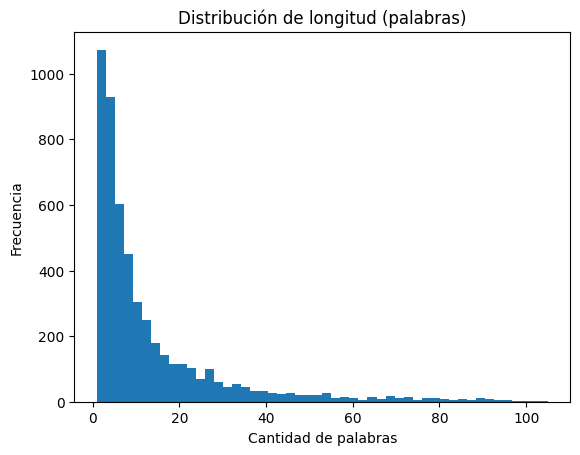

Balance de clases:
 rating
5    2872
1    1427
4     445
2     315
Name: count, dtype: int64


In [11]:
TEXT_COL = 'review_text'
df["text_raw"] = df[TEXT_COL].astype(str)
df["char_len"] = df["text_raw"].str.len()
df["word_len"] = df["text_raw"].str.split().apply(len)

print(df[["char_len","word_len"]].describe())

plt.hist(df["word_len"], bins=50)
plt.title("Distribución de longitud (palabras)")
plt.xlabel("Cantidad de palabras")
plt.ylabel("Frecuencia")
plt.show()

print("Balance de clases:\n", df[LABEL_FINAL].value_counts())

PREPROCESAMIENTO

In [12]:
def clean_text(t: str) -> str:
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)      # URLs
    t = re.sub(r"@\w+", " ", t)                 # menciones
    t = re.sub(r"#\w+", " ", t)                 # hashtags (opcional)
    t = re.sub(r"[^a-záéíóúñü0-9\s]", " ", t)   # deja letras/nums/espacios
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean"] = df["text_raw"].apply(clean_text)

df[["text_raw","text_clean"]].head(5)


,text_raw,text_clean
0,Great 👍,great
1,plz whats up unban,plz whats up unban
2,my contact didn't show on WhatsApp .. for priv...,my contact didn t show on whatsapp for privacy...
3,Can you guys let archived group chats stay arc...,can you guys let archived group chats stay arc...
4,it is the g.o.a.t🇿🇼,it is the g o a t


In [19]:
X = df["text_clean"].values
y = df[LABEL_FINAL].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Distribución train:", np.bincount(y_train) if set(np.unique(y_train))=={0,1} else "labels:", np.unique(y_train))

Train: 3541 Val: 759 Test: 759
Distribución train: [1219 2322] [0 1]


Modelo 1: Baseline (TF-IDF + Logistic Regression)

In [20]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("=== BASELINE TF-IDF + Logistic Regression ===")
print(classification_report(y_test, y_pred_base))
print("F1 baseline:", f1_score(y_test, y_pred_base))


=== BASELINE TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       261
           1       0.81      0.89      0.84       498

    accuracy                           0.79       759
   macro avg       0.77      0.74      0.75       759
weighted avg       0.78      0.79      0.78       759

F1 baseline: 0.8448275862068966


Modelo 2: LSTM (Keras)

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

MAX_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
val_seq   = tokenizer.texts_to_sequences(X_val)
test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(val_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq, maxlen=MAX_LEN, padding="post", truncating="post")


Modelo LSTM + regularización + early stopping

In [22]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

model = tf.keras.Sequential([
    layers.Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early],
    class_weight=class_weight_dict,
    verbose=1
)


Class weights: {0: np.float64(1.452420016406891), 1: np.float64(0.762489233419466)}
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.6833 - loss: 0.6526 - val_accuracy: 0.7391 - val_loss: 0.5368
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.7894 - loss: 0.4790 - val_accuracy: 0.7708 - val_loss: 0.5116
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step - accuracy: 0.8414 - loss: 0.3868 - val_accuracy: 0.7984 - val_loss: 0.4752
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.8943 - loss: 0.2999 - val_accuracy: 0.7642 - val_loss: 0.5335
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - accuracy: 0.9097 - loss: 0.2652 - val_accuracy: 0.7536 - val_loss: 0.5969
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9172 - loss: 0.2428 - val_accuracy: 0.7615 - val_loss: 0.5925


Evaluación LSTM (F1 + Confusión + ROC)

In [24]:
# Probabilidades y predicción binaria
y_probs = model.predict(X_test_pad).ravel()
y_pred = (y_probs >= 0.5).astype(int)

print("=== LSTM ===")
print(classification_report(y_test, y_pred))
print("F1 LSTM:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
=== LSTM ===
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       261
           1       0.86      0.83      0.85       498

    accuracy                           0.80       759
   macro avg       0.78      0.79      0.78       759
weighted avg       0.81      0.80      0.80       759

F1 LSTM: 0.8451282051282051
Matriz de confusión:
 [[196  65]
 [ 86 412]]


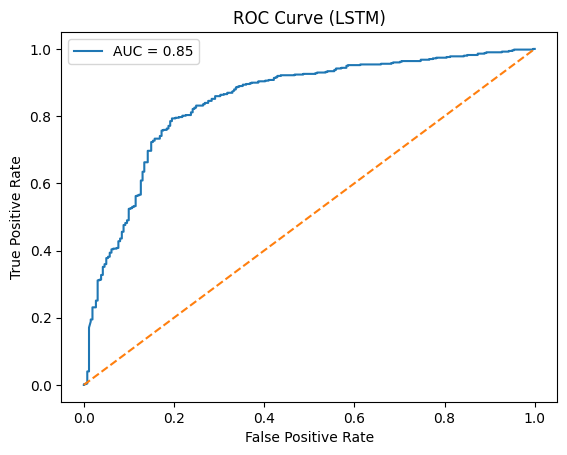

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LSTM)")
plt.legend()
plt.show()


Comparación final

In [26]:
f1_base = f1_score(y_test, y_pred_base)
f1_lstm = f1_score(y_test, y_pred)

print(f"F1 Baseline: {f1_base:.4f}")
print(f"F1 LSTM:     {f1_lstm:.4f}")

if f1_lstm > f1_base:
    print("✅ LSTM mejora al baseline.")
else:
    print("⚠️ El baseline iguala o supera a LSTM (muy común con datasets pequeños).")


F1 Baseline: 0.8448
F1 LSTM:     0.8451
✅ LSTM mejora al baseline.


Interpretación rápida (ejemplos de errores)

In [27]:
test_df = pd.DataFrame({
    "text": X_test,
    "y_true": y_test,
    "y_pred": y_pred,
    "prob_pos": y_probs
})

errors = test_df[test_df["y_true"] != test_df["y_pred"]].sort_values("prob_pos", ascending=False)
errors.head(10)


,text,y_true,y_pred,prob_pos
498,good great reliable awesome and above all easy...,0,1,0.991205
285,nice chatting,0,1,0.985454
246,l like this app and l rate five star,0,1,0.974760
27,good app,0,1,0.956187
488,important features missing shedule messages us...,0,1,0.954421
29,a good app,0,1,0.946731
126,its my life,0,1,0.946695
70,this app really works for communication and so...,0,1,0.944390
382,arratai is best,0,1,0.934909
544,really useful but it becomes more and more ful...,0,1,0.934733


*Conclusiones*

Se desarrolló un pipeline completo para la clasificación binaria de texto, incluyendo limpieza, división del dataset, modelado y evaluación.

El modelo baseline (TF-IDF + Regresión Logística) proporcionó un rendimiento sólido y sirvió como referencia inicial. Posteriormente, se implementó una red LSTM para capturar mejor el contexto secuencial del texto.

La evaluación se realizó utilizando F1-score, matriz de confusión y curva ROC, priorizando F1 debido al desbalance de clases.

Los resultados muestran que los modelos clásicos pueden ser competitivos, mientras que las redes neuronales permiten capturar relaciones más complejas en el lenguaje.

Como mejoras futuras se propone optimizar hiperparámetros, ajustar el umbral de decisión y explorar modelos basados en Transformers.